In [ ]:
from sklearn.decomposition import DictionaryLearning
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from utils import JumpReLU, Step
import math
import pandas as pd
import re
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
import os

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

## Loading

In [3]:
# Load the genomic dataset
model = torch.load("ae.pt", map_location=torch.device('cpu'))
X = model["decoder.weight"].detach().numpy() # shape [1024, 8192], already normalized

# Load the annotation set
val_set = pd.read_csv('val_set_0_nt500_batchtopk_standard_results.csv')
latent_f1_pairs = val_set[['latent_id', 'best_f1_val0']]

# Create a mapping from latent_id to best_f1_val0
latent_to_f1 = dict(zip(val_set['latent_id'],
val_set['best_f1_val0']))

# Map each feature index to its F1 score (0 if not in val_set)
feature_indices = range(8192)
f1_scores = np.array([latent_to_f1.get(idx, 0.0) for idx in
feature_indices])

# Define some tensor for training
X_tensor = torch.tensor(X.T, dtype=torch.float32)
X_tensor_selected = X_tensor[f1_scores > 0] # train only on F1 positive features


## SAE class 

In [4]:
input_dim = X.shape[0]
base_lr = 2e-4
warmup_epochs_lr = 10
warmup_epochs_alpha = 1000
epochs = 5000
batch_size = 512
bandwidth = 0.01

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, bandwidth):
        super().__init__()
        self.bandwidth = bandwidth
        self.dtype = torch.float32
        self.latent_dim = latent_dim
        self.device = device
        self.initialize_weights()
        self.threshold = nn.Parameter(torch.tensor([0.001], dtype=torch.float32))

    def initialize_weights(self):
        # decoder bias
        self.b_dec = nn.Parameter(torch.zeros(input_dim, dtype=self.dtype, device=self.device))
        # decoder weights
        w_dec_data = torch.empty(self.latent_dim, input_dim, dtype=self.dtype, device=self.device)
        nn.init.kaiming_uniform_(w_dec_data)
        self.W_dec = nn.Parameter(w_dec_data)
        # encoder weights = tied transpose of decoder
        w_enc_data = self.W_dec.data.T.clone().detach().contiguous()
        self.W_enc = nn.Parameter(w_enc_data)

    def forward(self, x):
        hidden_pre = x @ self.W_enc
        z = JumpReLU.apply(hidden_pre, self.threshold, self.bandwidth)
        x_hat = z @ self.W_dec + self.b_dec
        return x_hat, hidden_pre, z


## Train across latent dimension and sparsity coef

In [20]:
sweep_results = []

for latent_dim_index in [0, 128]: # latent dimension 0 means random dictionary and d = 128
    for base_alpha in [0.019, 0.022, 0.025]: 

        if latent_dim_index == 0: 
            X_random = torch.randn_like(X_tensor_selected)
            X_random_normalized = X_random / X_random.norm(dim=1, keepdim=True)
            dataset = torch.utils.data.TensorDataset(X_random_normalized)
            latent_dim = 128
            base_alpha = base_alpha - 0.012
        else: 
            dataset = torch.utils.data.TensorDataset(X_tensor_selected)
            latent_dim = latent_dim_index
            
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        # base_alpha = base_alpha + (latent_dim-64)/12800.0 # useful for comparaison

        model = SparseAutoencoder(input_dim, latent_dim, bandwidth).to(device)
        optimizer = optim.Adam(model.parameters(), lr=base_lr)

        recons, losses, sparsities, real_l0s, lrs, alphas = [], [], [], [], [], []

        for epoch in range(epochs):
            warmup_factor_lr = min((epoch + 1) / warmup_epochs_lr, 1.0)
            warmup_factor_alpha = min((epoch + 1) / warmup_epochs_alpha, 1.0)
            lr = base_lr * warmup_factor_lr
            alpha = base_alpha * 0.5 * (1 - math.cos(math.pi * warmup_factor_alpha))
            for g in optimizer.param_groups:
                g['lr'] = lr

            total_loss, total_sparsity, total_recons, total_real_l0 = 0, 0, 0, 0
            for (x_batch,) in loader:
                x_batch = x_batch.to(device)
                x_hat, hidden_pre, z = model(x_batch)

                recon_loss = torch.sum((x_hat - x_batch) ** 2, dim=1).mean()
                l0 = torch.sum(Step.apply(hidden_pre, model.threshold, model.bandwidth), dim=-1)
                l0_loss = alpha * l0.mean()

                loss = recon_loss + l0_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # --- monitoring ---
                real_l0 = (torch.abs(z) > 0).float().sum(dim=1).mean().item()

                total_loss += loss.item()
                total_recons += recon_loss.item()
                total_sparsity += l0.mean().item()
                total_real_l0 += real_l0

            avg_loss = total_loss / len(loader)
            avg_recons = total_recons / len(loader)
            avg_sparsity = total_sparsity / len(loader)
            avg_real_l0 = total_real_l0 / len(loader)

            losses.append(avg_loss)
            recons.append(avg_recons)
            sparsities.append(avg_sparsity)
            real_l0s.append(avg_real_l0)
            lrs.append(lr)
            alphas.append(alpha)

            if epoch % 100 == 0 or epoch == epochs - 1:
                print(f"[Dim={latent_dim_index}, α={base_alpha:.3f}] Epoch {epoch+1:04d} | "
                      f"Recon={avg_recons:.4f} | RealL0={avg_real_l0:.1f}")
        
        # Store final results
        sweep_results.append({
            'latent_dim': latent_dim_index,
            'alpha': base_alpha,
            'final_recon': recons[-1],
            'final_l0': real_l0s[-1]
        })

# Convert to DataFrame
results_df = pd.DataFrame(sweep_results)
print("\nSweep complete! Results summary:")
print(results_df)

[Dim=0, α=0.007] Epoch 0001 | Recon=1.0142 | RealL0=62.7
[Dim=0, α=0.007] Epoch 0101 | Recon=0.8385 | RealL0=61.9
[Dim=0, α=0.007] Epoch 0201 | Recon=0.7833 | RealL0=50.9
[Dim=0, α=0.007] Epoch 0301 | Recon=0.7596 | RealL0=41.6
[Dim=0, α=0.007] Epoch 0401 | Recon=0.7558 | RealL0=33.2
[Dim=0, α=0.007] Epoch 0501 | Recon=0.7594 | RealL0=26.6
[Dim=0, α=0.007] Epoch 0601 | Recon=0.7635 | RealL0=22.0
[Dim=0, α=0.007] Epoch 0701 | Recon=0.7647 | RealL0=19.4
[Dim=0, α=0.007] Epoch 0801 | Recon=0.7821 | RealL0=15.3
[Dim=0, α=0.007] Epoch 0901 | Recon=0.7748 | RealL0=14.9
[Dim=0, α=0.007] Epoch 1001 | Recon=0.7768 | RealL0=13.9
[Dim=0, α=0.007] Epoch 1101 | Recon=0.7769 | RealL0=13.1
[Dim=0, α=0.007] Epoch 1201 | Recon=0.7786 | RealL0=12.5
[Dim=0, α=0.007] Epoch 1301 | Recon=0.7795 | RealL0=12.0
[Dim=0, α=0.007] Epoch 1401 | Recon=0.7807 | RealL0=11.5
[Dim=0, α=0.007] Epoch 1501 | Recon=0.7811 | RealL0=11.2
[Dim=0, α=0.007] Epoch 1601 | Recon=0.7819 | RealL0=10.9
[Dim=0, α=0.007] Epoch 1701 | R

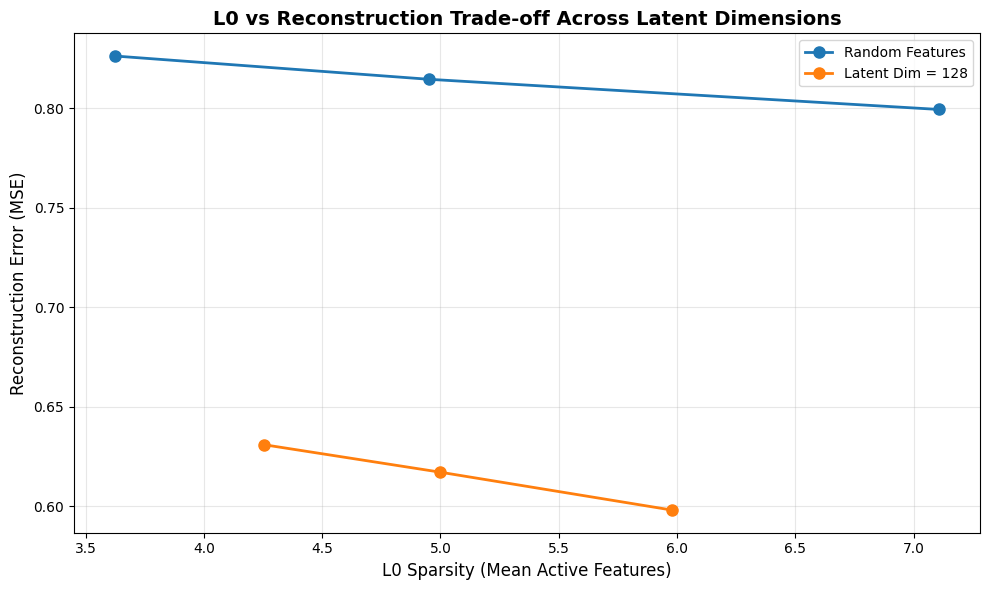

In [21]:
# Plot L0 vs Reconstruction for different latent dimensions
plt.figure(figsize=(10, 6))

# Pick 4 representative latent dimensions to plot
dims_to_plot = [0, 128]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for dim, color in zip(dims_to_plot, colors):
    subset = results_df[results_df['latent_dim'] == dim]
    plt.plot(subset['final_l0'], subset['final_recon'], 
             'o-', label=(f'Latent Dim = {dim}' if dim != 0 else 'Random Features'), 
             color=color, markersize=8, linewidth=2)

plt.xlabel('L0 Sparsity (Mean Active Features)', fontsize=12)
plt.ylabel('Reconstruction Error (MSE)', fontsize=12)
plt.title('L0 vs Reconstruction Trade-off Across Latent Dimensions', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Saves excel file with meta-sae features (for the last trained model) and corresponding children annotations

In [ ]:
has_positive_f1 = f1_scores > 0
feature_indices = range(8192)
latent_to_annotation = dict(zip(val_set['latent_id'], val_set['annotation']))
annotations = [latent_to_annotation.get(idx) for idx in feature_indices if idx in latent_to_annotation]
items = [re.findall(r"'([^']+)'", s) for s in annotations]

Z = model(X_tensor[has_positive_f1].to('mps'))[2] > 0 

k = 20 # number of rows to show
values, indices = torch.topk(model(X_tensor[has_positive_f1].to("mps"))[2], k=k, dim=0)
mask = torch.zeros_like(Z, dtype=torch.bool)
mask.scatter_(0, indices, True)
Z_top10 = torch.where(mask, Z, torch.zeros_like(Z))

# Calculate importance score for each latent dimension
decoder_norms = model.W_dec.norm(dim=1).cpu() 
mean_activations = values.mean(dim=0).cpu()
importance_scores = (mean_activations * decoder_norms).detach().numpy()

min_score = importance_scores.min()
max_score = importance_scores.max()
normalized_scores = (importance_scores - min_score) / (max_score - min_score + 1e-10)
normalized_scores = np.clip(normalized_scores, 0.0, 0.4)  # Clip to [0, 1]
normalized_scores = normalized_scores / 0.4

N = Z_top10.shape[1]
all_columns = {}

for i in range(N):
    mask_col = Z_top10[:, i].cpu().numpy()
    selected = [x for x, m in zip(items, mask_col) if m]
    all_columns[f"Column_{i+1}"] = pd.Series(selected)

df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_columns.items()]))

# Save to Excel
output_file = f"meta_sae_annotations_D{latent_dim}_L0:{avg_real_l0:.0f}.xlsx"
df.to_excel(output_file, index=False)

wb = load_workbook(output_file)
ws = wb.active

for i in range(N):
    col_idx = i + 1  # Excel columns are 1-indexed
    score = normalized_scores[i]
    
    r = int(255 * (1 - score))
    g = int(255 * (1 - score))
    b = 255
    
    rgb = f"{r:02X}{g:02X}{b:02X}"
    fill = PatternFill(start_color=rgb, end_color=rgb, fill_type="solid")
    ws.cell(row=1, column=col_idx).fill = fill

# Save the colored workbook
wb.save(output_file)

torch.save(model.W_dec.detach().cpu(), f"meta_sae_decoder_weights_D{latent_dim}_L0:{avg_real_l0:.0f}.pt")

print(f"Saved colored Excel file to: {output_file}")
print(f"Importance score range: [{min_score:.4f}, {max_score:.4f}]")
print(f"Color scheme: White (low) → Blue (high, capped at 0.5)")


Saved colored Excel file to: meta_sae_annotations_D128_L0:4.xlsx
Importance score range: [0.3435, 0.7878]
Color scheme: White (low) → Blue (high, capped at 0.5)


## Clustering

In [ ]:
annotations_to_keep = ["Ac5 promoter", "chimeric intron", "EGFP", "env",
                       "HIV-1 gag", "KanMX", "P", "PuroR"]

X_clustering = X_tensor[has_positive_f1].cpu().numpy()
flat_items = []
for entry in items:
    if isinstance(entry, (list, tuple)) and len(entry) > 0:
        flat_items.append(entry[0])
    elif isinstance(entry, str):
        flat_items.append(entry)
    else:
        flat_items.append("Unknown")

annotations_to_keep = list(dict.fromkeys(annotations_to_keep))
present_kept = [ann for ann in annotations_to_keep if ann in set(flat_items)]
if not present_kept:
    raise ValueError("None of the requested annotations_to_keep are present in your items.")

# Compute t-SNE projection
print("Running t-SNE embedding...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_clustering)

cmap = plt.get_cmap("tab10", len(present_kept))
ann_to_color = {ann: cmap(i) for i, ann in enumerate(present_kept)}
ann_to_idx = {ann: np.array([i for i, a in enumerate(flat_items) if a == ann]) for ann in present_kept}

output_dir = "tsne_annotation_plots"
os.makedirs(output_dir, exist_ok=True)

plt.style.use("seaborn-v0_8-white")
fig, ax = plt.subplots(figsize=(4, 4))  # smaller square canvas

ax.scatter(X_tsne[:, 0], X_tsne[:, 1], s=18, color="#d0d0d0", alpha=0.4, label="Other/Not shown")

for ann in present_kept:
    idx = ann_to_idx[ann]
    if idx.size > 0:
        ax.scatter(
            X_tsne[idx, 0], X_tsne[idx, 1],
            s=60, alpha=0.9, label=f"{ann} ({idx.size})",
            color=ann_to_color[ann], edgecolors="white", linewidth=0.4
        )

ax.set_xlabel("t-SNE 1", fontsize=10, labelpad=10)
ax.set_ylabel("t-SNE 2", fontsize=10, labelpad=10)
# ax.set_title("t-SNE of Selected Genetic Annotations", fontsize=15, weight="semibold", pad=15)

# for spine in ax.spines.values():
#     spine.set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=10, colors="#333333")

ax.set_aspect("equal", adjustable="box")  # same scaling

leg = ax.legend(
    loc="center left", bbox_to_anchor=(1.05, 0.5), 
    frameon=False, fontsize=11, title="Annotations", title_fontsize=14
)

fig.patch.set_facecolor("white")

outfile = os.path.join(output_dir, "tsne_selected_annotations.png")
fig.savefig(outfile, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.close(fig)

Running t-SNE embedding...


# Less important stuff

## Using dictionary learning

In [ ]:
# takes a couple of minutes to run
alphas = [0.025]

sparsities = []
recon_errors = []

for alpha in alphas:
    dict_learner = DictionaryLearning(
        n_components=64,
        alpha=alpha,
        max_iter=1000, 
        tol=1e-08,
        fit_algorithm='lars',
        transform_algorithm='lasso_cd',
        random_state=0
    )
    
    Z = dict_learner.fit_transform(X.T)
    D = dict_learner.components_
    
    tol = 0
    sparsity = np.mean(np.sum(np.abs(Z) > tol, axis=1))
    print(sparsity)
    sparsities.append(sparsity)
    
    X_recon = Z @ D
    error = np.sum((X.T - X_recon)**2, axis=1).mean()
    print(error.shape)
    recon_errors.append(error)
    
    print(f"alpha={alpha:.3f} | sparsity={sparsity:.3f} | MSE={error:.4f}")

# 3. Plot sparsity vs reconstruction error
plt.figure(figsize=(6,4))
plt.plot(sparsities, recon_errors, 'o-', lw=2)
plt.xlabel("Sparsity (fraction of zeros)")
plt.ylabel("Reconstruction MSE")
plt.title("Sparsity vs Reconstruction Error")
plt.gca().invert_xaxis()  # optional: more sparse → left
plt.grid(True)
plt.show()


KeyboardInterrupt: 

## Using the full dictionary, not only the f1 > 0 features

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from utils import JumpReLU, Step

X_random= torch.randn(1024, 8192)
X_random_normalized = X_random / X_random.norm(dim=0, keepdim=True)
X_tensor = torch.tensor(X.T, dtype=torch.float32)
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = X.shape[0]
latent_dim = 256
base_lr = 2e-4
base_alpha = 0.0075
warmup_epochs_lr = 10
warmup_epochs_alpha = 1000
epochs = 2000
batch_size = 1024
bandwidth = 0.01

dataset = torch.utils.data.TensorDataset(X_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, bandwidth):
        super().__init__()
        self.bandwidth = bandwidth
        self.dtype = torch.float32
        self.device = device
        self.initialize_weights()
        self.threshold = nn.Parameter(torch.tensor([0.001], dtype=torch.float32))

    def initialize_weights(self):
        # decoder bias
        self.b_dec = nn.Parameter(torch.zeros(input_dim, dtype=self.dtype, device=self.device))
        # decoder weights
        w_dec_data = torch.empty(latent_dim, input_dim, dtype=self.dtype, device=self.device)
        nn.init.kaiming_uniform_(w_dec_data)
        self.W_dec = nn.Parameter(w_dec_data)
        # encoder weights = tied transpose of decoder
        w_enc_data = self.W_dec.data.T.clone().detach().contiguous()
        self.W_enc = nn.Parameter(w_enc_data)

    def forward(self, x):
        hidden_pre = x @ self.W_enc
        z = JumpReLU.apply(hidden_pre, self.threshold, self.bandwidth)
        x_hat = z @ self.W_dec + self.b_dec
        return x_hat, hidden_pre, z


model = SparseAutoencoder(input_dim, latent_dim, bandwidth).to(device)
optimizer = optim.Adam(model.parameters(), lr=base_lr)

recons, losses, sparsities, real_l0s, lrs, alphas = [], [], [], [], [], []

for epoch in range(epochs):
    warmup_factor_lr = min((epoch + 1) / warmup_epochs_lr, 1.0)
    warmup_factor_alpha = min((epoch + 1) / warmup_epochs_alpha, 1.0)
    lr = base_lr * warmup_factor_lr
    alpha = base_alpha * 0.5 * (1 - math.cos(math.pi * warmup_factor_alpha))
    for g in optimizer.param_groups:
        g['lr'] = lr

    total_loss, total_sparsity, total_recons, total_real_l0 = 0, 0, 0, 0
    for (x_batch,) in loader:
        x_batch = x_batch.to(device)
        x_hat, hidden_pre, z = model(x_batch)

        recon_loss = torch.sum((x_hat - x_batch) ** 2, dim=1).mean()
        l0 = torch.sum(Step.apply(hidden_pre, model.threshold, model.bandwidth), dim=-1)
        l0_loss = alpha * l0.mean()

        loss = recon_loss + l0_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- monitoring ---
        real_l0 = (torch.abs(z) > 0).float().sum(dim=1).mean().item()

        total_loss += loss.item()
        total_recons += recon_loss.item()
        total_sparsity += l0.mean().item()
        total_real_l0 += real_l0

    avg_loss = total_loss / len(loader)
    avg_recons = total_recons / len(loader)
    avg_sparsity = total_sparsity / len(loader)
    avg_real_l0 = total_real_l0 / len(loader)

    losses.append(avg_loss)
    recons.append(avg_recons)
    sparsities.append(avg_sparsity)
    real_l0s.append(avg_real_l0)
    lrs.append(lr)
    alphas.append(alpha)

    print(f"Epoch {epoch+1:04d} | α={alpha:.4f} | lr={lr:.6f} | "
          f"Total={avg_loss:.4f} | Recon={avg_recons:.4f} | L0={avg_sparsity:.4f} | RealL0={avg_real_l0:.1f}")

plt.figure(figsize=(8,5))
plt.plot(losses, label='Total Loss', color='tab:red')
plt.plot(recons, label='Reconstruction MSE', color='tab:blue')
# set log scale
plt.yscale('log')
plt.plot(sparsities, label='Mean L0 (Step)', color='tab:orange', linestyle='--')
plt.plot(real_l0s, label='Real L0 (Nonzero activations)', color='tab:green', linestyle=':')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Dynamics: Total Loss, Reconstruction, L0 and Real L0 Sparsity')
plt.legend()
plt.grid(True)
plt.show()

Epoch 0001 | α=0.0000 | lr=0.000020 | Total=1.0552 | Recon=1.0552 | L0=125.3990 | RealL0=125.4
Epoch 0002 | α=0.0000 | lr=0.000040 | Total=1.0291 | Recon=1.0291 | L0=125.0316 | RealL0=125.0
Epoch 0003 | α=0.0000 | lr=0.000060 | Total=0.9927 | Recon=0.9927 | L0=125.4155 | RealL0=125.4
Epoch 0004 | α=0.0000 | lr=0.000080 | Total=0.9552 | Recon=0.9552 | L0=126.4894 | RealL0=126.5
Epoch 0005 | α=0.0000 | lr=0.000100 | Total=0.9235 | Recon=0.9234 | L0=127.3976 | RealL0=127.4
Epoch 0006 | α=0.0000 | lr=0.000120 | Total=0.8999 | Recon=0.8998 | L0=126.7903 | RealL0=126.8
Epoch 0007 | α=0.0000 | lr=0.000140 | Total=0.8834 | Recon=0.8832 | L0=126.1061 | RealL0=126.1
Epoch 0008 | α=0.0000 | lr=0.000160 | Total=0.8717 | Recon=0.8715 | L0=126.3920 | RealL0=126.4
Epoch 0009 | α=0.0000 | lr=0.000180 | Total=0.8627 | Recon=0.8625 | L0=126.1758 | RealL0=126.2
Epoch 0010 | α=0.0000 | lr=0.000200 | Total=0.8551 | Recon=0.8549 | L0=126.2535 | RealL0=126.3
Epoch 0011 | α=0.0000 | lr=0.000200 | Total=0.8484

KeyboardInterrupt: 

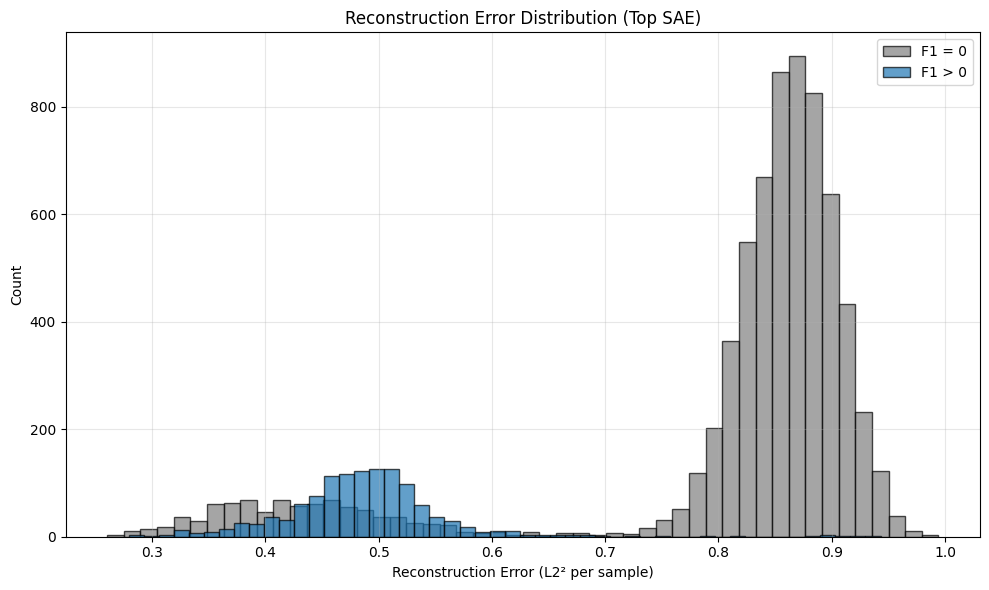

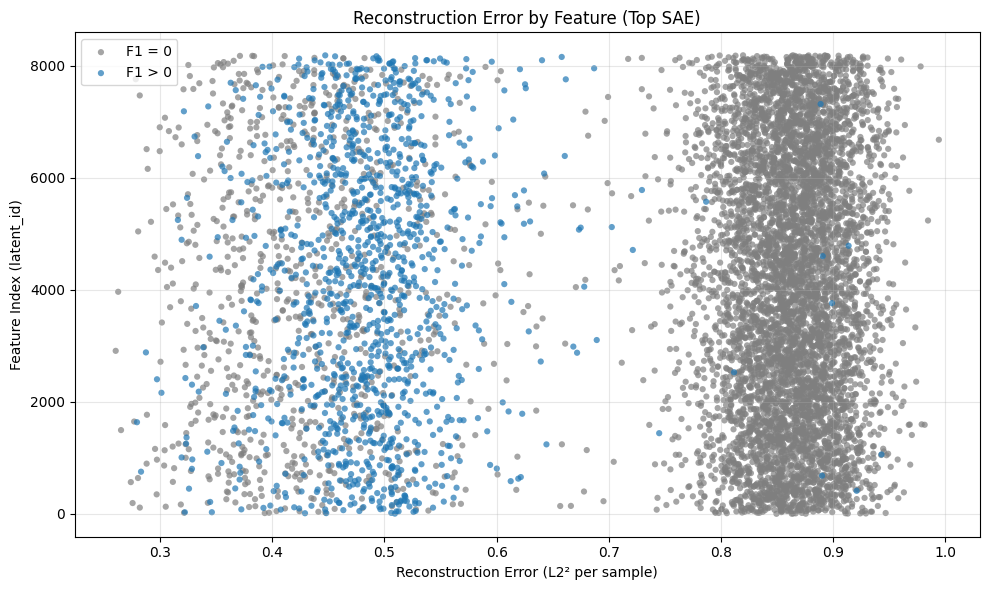

Features with F1 > 0: 1209
Features with F1 = 0: 6983


In [ ]:
# Load the validation set
val_set = pd.read_csv('val_set_0_nt500_batchtopk_standard_results.csv')
latent_f1_pairs = val_set[['latent_id', 'best_f1_val0']]

model.eval()
with torch.no_grad():
    X_tensor = X_tensor.to(device)
    X_hat, _, _ = model(X_tensor)
    recon_errors = torch.sum((X_tensor - X_hat) ** 2,
dim=1).cpu().numpy()

latent_to_f1 = dict(zip(val_set['latent_id'],
val_set['best_f1_val0']))
feature_indices = range(len(recon_errors))
f1_scores = np.array([latent_to_f1.get(idx, 0.0) for idx in
feature_indices])

has_f1 = f1_scores > 0
no_f1 = f1_scores == 0

plt.figure(figsize=(10, 6))
plt.hist(recon_errors[no_f1], bins=50, color='tab:gray',
alpha=0.7, edgecolor='k', label='F1 = 0')
plt.hist(recon_errors[has_f1], bins=50, color='tab:blue',
alpha=0.7, edgecolor='k', label='F1 > 0')
plt.xlabel("Reconstruction Error (L2² per sample)")
plt.ylabel("Count")
plt.title(f"Reconstruction Error Distribution (Top SAE)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(recon_errors[no_f1],
np.array(feature_indices)[no_f1],
            c='tab:gray', alpha=0.7, s=20, edgecolors='none',
label='F1 = 0')
plt.scatter(recon_errors[has_f1],
np.array(feature_indices)[has_f1],
            c='tab:blue', alpha=0.7, s=20, edgecolors='none',
label='F1 > 0')
plt.xlabel("Reconstruction Error (L2² per sample)")
plt.ylabel("Feature Index (latent_id)")
plt.title(f"Reconstruction Error by Feature (Top SAE)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Features with F1 > 0: {has_f1.sum()}")
print(f"Features with F1 = 0: {no_f1.sum()}")
# # Alternative: Histogram with bars colored by mean F1 in each bin
# plt.figure(figsize=(10, 6))
# counts, bins, patches = plt.hist(recon_errors, bins=50,
# edgecolor='k', alpha=0.7)

# # Color each bin by the mean F1 score of samples in that bin
# bin_indices = np.digitize(recon_errors, bins) - 1
# for i, patch in enumerate(patches):
#     mask = (bin_indices == i)
#     mean_f1 = f1_scores[mask].mean() if mask.any() else 0
#     color = plt.cm.viridis(mean_f1 / (f1_scores.max() if
# f1_scores.max() > 0 else 1))
#     patch.set_facecolor(color)

# sm = plt.cm.ScalarMappable(cmap='viridis',
#                             norm=plt.Normalize(vmin=0,
# vmax=f1_scores.max()))
# sm.set_array([])
# plt.colorbar(sm, label='Mean Best F1 Score')
# plt.xlabel("Reconstruction Error (L2² per sample)")
# plt.ylabel("Count")
# plt.title(f"Reconstruction Error Distribution (Top SAE)")
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

## Random stuff to keep if ever

In [ ]:
# 🧬 Reporter Genes
reporter_genes = [
    "EGFP", "eGFP", "GFP", "mCherry", "dsRed",
    "ECFP", "Luc2", "Luciferase"
]

# 💊 Selectable Markers
selectable_markers = [
    "AmpR", "ampR promoter", "bla", "bla promoter", "β-lactamase",
    "KanR", "kanMX", "KanMX", "NeoR", "neo",
    "GmR", "PuroR", "puromycin resistance gene",
    "hygromycin resistance gene", "hph"
]

# ⚙️ Promoters & Enhancers
promoters_enhancers = [
    "CMV promoter", "CMV enhancer", "CMV intron", "CMV enhancer + IE94 promoter",
    "EF-1α promoter", "EF-1α intron A",
    "chicken β-actin promoter", "β-actin promoter",
    "SV40 promoter", "SV40 enhancer", "SV40 early promoter",
    "hEF-1α promoter", "hPGK promoter", "hH1 promoter", "H1 promoter",
    "U6 promoter", "TK promoter", "SP6 promoter", "T7 promoter",
    "Hsp70 promoter", "Ac5 promoter", "Ubiquitin promoter", "lac promoter"
]

# 🧩 Terminators & PolyA Signals
terminators_polyA = [
    "rrnB T1 terminator", "SV40 polyA signal",
    "polyA signal", "terminator"
]

# 🔁 Origins of Replication
origins_of_replication = [
    "Ori", "oriC", "p15A origin", "pUC origin",
    "f1 origin", "SV40 origin of replication"
]

# 🧠 Regulatory / Expression Control Elements
regulatory_elements = [
    "IRES", "T2A", "P2A", "wPRE", "loxP", "attB",
    "tetO", "tetR", "tTA", "LacI", "LacO",
    "lacZ", "LacZα", "MCS", "ccdB"
]

# 🧫 Viral / Packaging Elements
viral_elements = [
    "HIV-1 LTR", "LTR (ΔU3)", "LTR (truncated)",
    "HIV-1 Ψ", "HIV-1 SL3", "RRE",
    "AAV2 ITR", "VSV-G", "wPRE"
]

# 🧪 Protein Tags & Fusion Sequences
protein_tags = [
    "3xFLAG", "3xHA", "9xHis",
    "cMyc", "tPA signal peptide", "H2B"
]

# 🧬 Genes / Coding Sequences of Interest
genes_of_interest = [
    "Cas9", "spCas9", "Cas9(C)",
    "DMRTC2", "EWSR1", "EZR", "FYN",
    "ENO", "C9orf85", "Lamin B receptor",
    "β-globin intron"
]


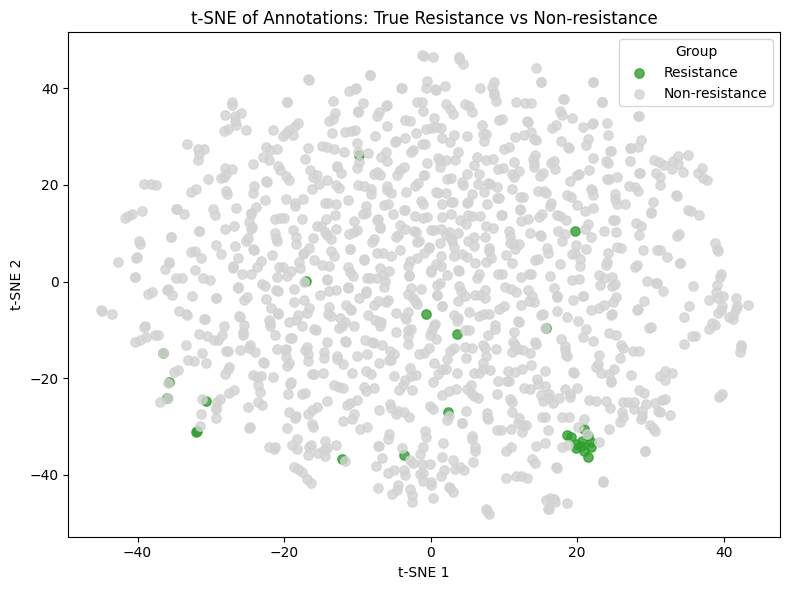

Resistance: 27 items (2.2%)
Non-resistance: 1182 items (97.8%)


In [284]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Normalize items list ---
flat_items = []
for entry in items:
    if isinstance(entry, (list, tuple)) and len(entry) > 0:
        flat_items.append(entry[0])
    elif isinstance(entry, str):
        flat_items.append(entry)
    else:
        flat_items.append("Unknown")

# --- Define real resistance genes only ---
true_resistance_genes = [
    # # β-lactam (ampicillin)
    # "AmpR", "bla", "β-lactamase",
    # # Kanamycin / Neomycin
    # "KanR", "kanMX", "KanMX", "NeoR", "neo",
    # Puromycin
    "chimeric intron",
    # # Hygromycin
    # "HygroR", "hygromycin resistance gene", "hph",
    # # Gentamicin
    # "GmR", "gentamicin resistance gene"
]

# --- Assign group (Resistance vs Non-resistance) ---
def assign_group(annotation):
    if annotation in true_resistance_genes:
        return "Resistance"
    return "Non-resistance"

group_labels = [assign_group(a) for a in flat_items]

# --- t-SNE projection (2D) ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_clustering)

# --- Plot ---
plt.figure(figsize=(8, 6))
colors = {"Resistance": "tab:green", "Non-resistance": "lightgray"}

for group in ["Resistance", "Non-resistance"]:
    idx = [i for i, g in enumerate(group_labels) if g == group]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                s=45, alpha=0.8, c=colors[group], label=group)

plt.legend(title="Group")
plt.title("t-SNE of Annotations: True Resistance vs Non-resistance")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

# --- Summary ---
n_res = sum(g == "Resistance" for g in group_labels)
n_non = sum(g == "Non-resistance" for g in group_labels)
print(f"Resistance: {n_res} items ({100*n_res/len(group_labels):.1f}%)")
print(f"Non-resistance: {n_non} items ({100*n_non/len(group_labels):.1f}%)")


In [ ]:
# 🧬 Reporter Genes
reporter_genes = [
    "EGFP", "eGFP", "GFP", "mCherry", "dsRed",
    "ECFP", "Luc2", "Luciferase"
]

# 💊 Selectable Markers
selectable_markers = [
    "AmpR", "ampR promoter", "bla", "bla promoter", "β-lactamase",
    "KanR", "kanMX", "KanMX", "NeoR", "neo",
    "GmR", "PuroR", "puromycin resistance gene",
    "hygromycin resistance gene", "hph"
]

# ⚙️ Promoters & Enhancers
promoters_enhancers = [
    "CMV promoter", "CMV enhancer", "CMV intron", "CMV enhancer + IE94 promoter",
    "EF-1α promoter", "EF-1α intron A",
    "chicken β-actin promoter", "β-actin promoter",
    "SV40 promoter", "SV40 enhancer", "SV40 early promoter",
    "hEF-1α promoter", "hPGK promoter", "hH1 promoter", "H1 promoter",
    "U6 promoter", "TK promoter", "SP6 promoter", "T7 promoter",
    "Hsp70 promoter", "Ac5 promoter", "Ubiquitin promoter", "lac promoter"
]

# 🧩 Terminators & PolyA Signals
terminators_polyA = [
    "rrnB T1 terminator", "SV40 polyA signal",
    "polyA signal", "terminator"
]

# 🔁 Origins of Replication
origins_of_replication = [
    "Ori", "oriC", "p15A origin", "pUC origin",
    "f1 origin", "SV40 origin of replication"
]

# 🧠 Regulatory / Expression Control Elements
regulatory_elements = [
    "IRES", "T2A", "P2A", "wPRE", "loxP", "attB",
    "tetO", "tetR", "tTA", "LacI", "LacO",
    "lacZ", "LacZα", "MCS", "ccdB"
]

# 🧫 Viral / Packaging Elements
viral_elements = [
    "HIV-1 LTR", "LTR (ΔU3)", "LTR (truncated)",
    "HIV-1 Ψ", "HIV-1 SL3", "RRE",
    "AAV2 ITR", "VSV-G", "wPRE"
]

# 🧪 Protein Tags & Fusion Sequences
protein_tags = [
    "3xFLAG", "3xHA", "9xHis",
    "cMyc", "tPA signal peptide", "H2B"
]

# 🧬 Genes / Coding Sequences of Interest
genes_of_interest = [
    "Cas9", "spCas9", "Cas9(C)",
    "DMRTC2", "EWSR1", "EZR", "FYN",
    "ENO", "C9orf85", "Lamin B receptor",
    "β-globin intron"
]


Data shape: (1209, 1024)
Computing t-SNE...
t-SNE complete!
Running K-Means...
Running Gaussian Mixture...
Running Hierarchical...
Running DBSCAN...


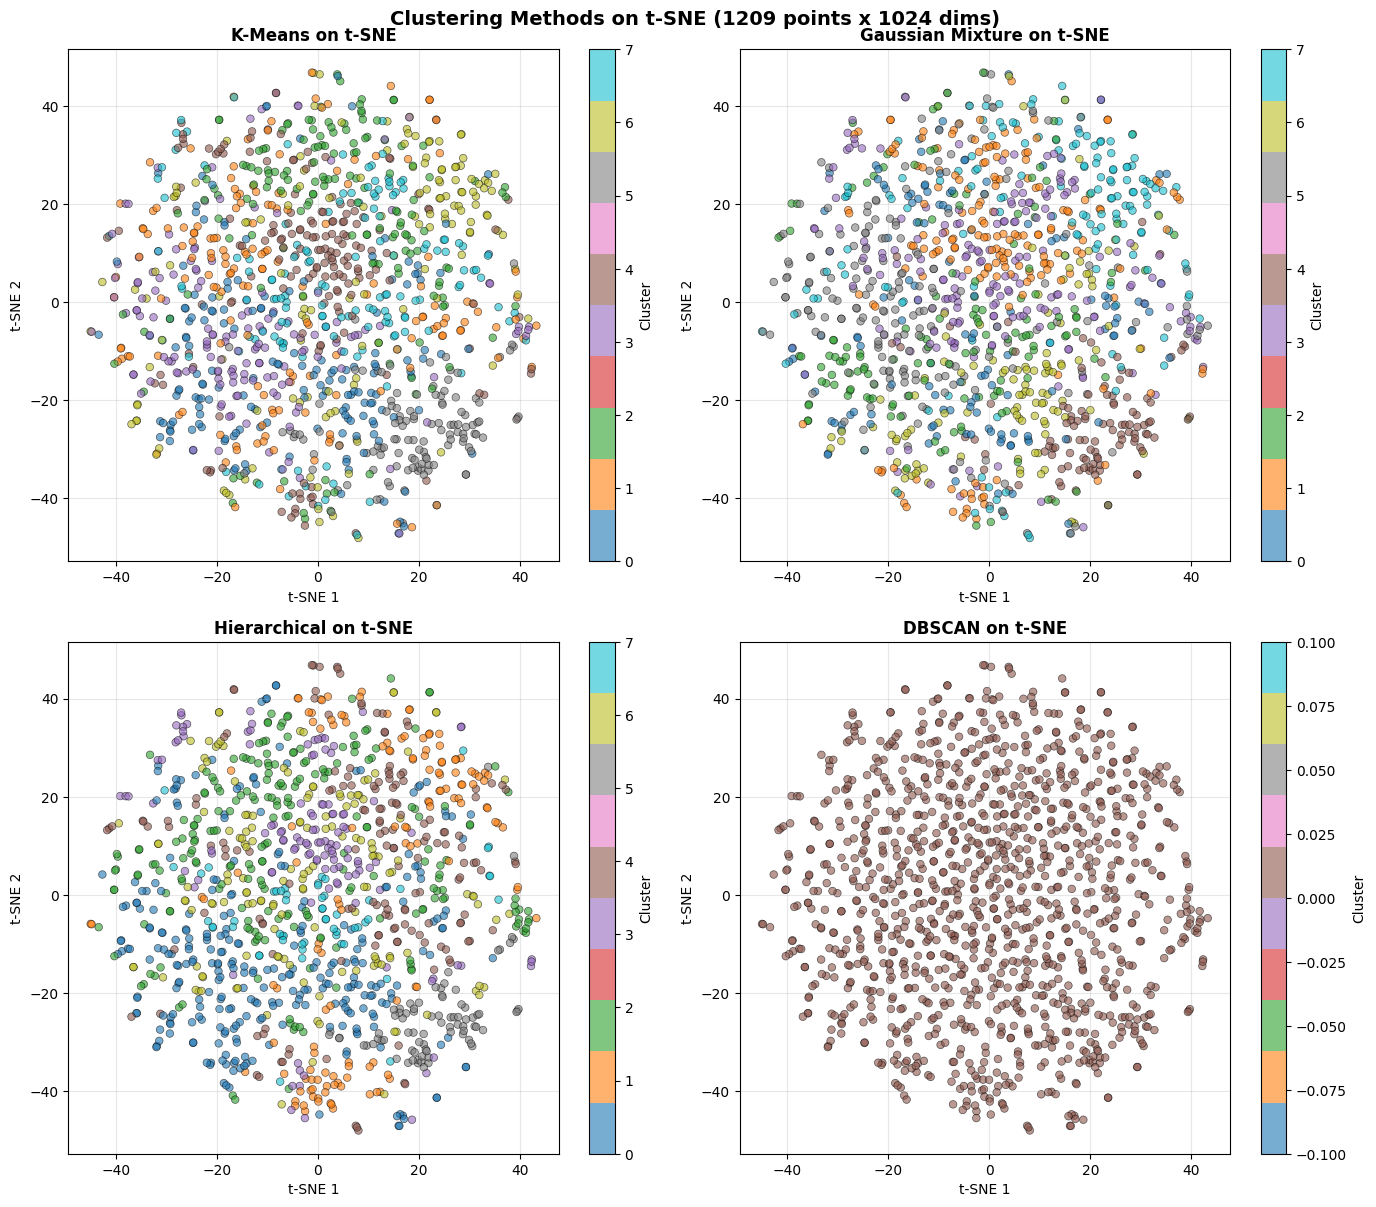


Cluster counts:
K-Means: [171 161 153 151 167 120 142 144]
GMM: [131 175 148 189 108 194 112 152]
Hierarchical: [286 137 220 121 159  81 149  56]
DBSCAN: [1209] + 0 noise


In [ ]:
# Apply t-SNE and clustering to X_tensor_subset
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
X_clustering = X_tensor[has_positive_f1].cpu().numpy()
items

print(f"Data shape: {X_clustering.shape}")

# Apply t-SNE
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_clustering)
print("t-SNE complete!")

# Apply different clustering methods
n_clusters = 8

print("Running K-Means...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_clustering)

print("Running Gaussian Mixture...")
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
labels_gmm = gmm.fit_predict(X_clustering)

print("Running Hierarchical...")
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
labels_hierarchical = hierarchical.fit_predict(X_clustering)

print("Running DBSCAN...")
dbscan = DBSCAN(eps=3.0, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_clustering)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

methods = [
    ('K-Means', labels_kmeans),
    ('Gaussian Mixture', labels_gmm),
    ('Hierarchical', labels_hierarchical),
    ('DBSCAN', labels_dbscan)
]

for idx, (name, labels) in enumerate(methods):
    ax = axes[idx // 2, idx % 2]
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', 
                        s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
    ax.set_title(f'{name} on t-SNE', fontsize=12, fontweight='bold')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.suptitle('Clustering Methods on t-SNE (1209 points x 1024 dims)', 
             fontsize=14, fontweight='bold', y=1.002)
plt.show()

print(f"\nCluster counts:")
print(f"K-Means: {np.bincount(labels_kmeans)}")
print(f"GMM: {np.bincount(labels_gmm)}")
print(f"Hierarchical: {np.bincount(labels_hierarchical)}")
print(f"DBSCAN: {np.bincount(labels_dbscan[labels_dbscan >= 0])} + {np.sum(labels_dbscan == -1)} noise")